# Double DQN, Deep Q Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = 'LunarLander-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(8,)
Action space Discrete(4)


## Build DQN Architecture

In [9]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        Qsa = self.fc3_layer(state)
        
        return Qsa        

## Set Replay Buffer

In [10]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define Double DQN Agent

In [11]:
class Double_DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [12]:
agent = Double_DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [13]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [14]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/Double_DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=2000, max_time=1000)

Episode: 100, Average Score: -162.50
Episode: 200, Average Score: -133.88
Episode: 300, Average Score: -69.032
Episode: 400, Average Score: 3.9214
Episode: 500, Average Score: 92.22
Episode: 600, Average Score: 158.25
Episode: 700, Average Score: 189.76
Episode: 732, Average Score: 200.64
Environment solved in 632 episodes! Average Score: 200.64
Episode: 733, Average Score: 200.56
Environment solved in 633 episodes! Average Score: 200.56
Episode: 734, Average Score: 200.65
Environment solved in 634 episodes! Average Score: 200.65
Episode: 735, Average Score: 201.55
Environment solved in 635 episodes! Average Score: 201.55
Episode: 736, Average Score: 203.83
Environment solved in 636 episodes! Average Score: 203.83
Episode: 737, Average Score: 204.73
Environment solved in 637 episodes! Average Score: 204.73
Episode: 738, Average Score: 204.98
Environment solved in 638 episodes! Average Score: 204.98
Episode: 739, Average Score: 205.08
Environment solved in 639 episodes! Average Score: 2

Episode: 817, Average Score: 233.12
Environment solved in 717 episodes! Average Score: 233.12
Episode: 818, Average Score: 232.67
Environment solved in 718 episodes! Average Score: 232.67
Episode: 819, Average Score: 232.26
Environment solved in 719 episodes! Average Score: 232.26
Episode: 820, Average Score: 233.12
Environment solved in 720 episodes! Average Score: 233.12
Episode: 821, Average Score: 233.74
Environment solved in 721 episodes! Average Score: 233.74
Episode: 822, Average Score: 233.28
Environment solved in 722 episodes! Average Score: 233.28
Episode: 823, Average Score: 232.91
Environment solved in 723 episodes! Average Score: 232.91
Episode: 824, Average Score: 233.15
Environment solved in 724 episodes! Average Score: 233.15
Episode: 825, Average Score: 233.61
Environment solved in 725 episodes! Average Score: 233.61
Episode: 826, Average Score: 234.21
Environment solved in 726 episodes! Average Score: 234.21
Episode: 827, Average Score: 233.90
Environment solved in 72

Episode: 905, Average Score: 229.74
Environment solved in 805 episodes! Average Score: 229.74
Episode: 906, Average Score: 230.31
Environment solved in 806 episodes! Average Score: 230.31
Episode: 907, Average Score: 226.87
Environment solved in 807 episodes! Average Score: 226.87
Episode: 908, Average Score: 226.95
Environment solved in 808 episodes! Average Score: 226.95
Episode: 909, Average Score: 226.73
Environment solved in 809 episodes! Average Score: 226.73
Episode: 910, Average Score: 226.61
Environment solved in 810 episodes! Average Score: 226.61
Episode: 911, Average Score: 225.31
Environment solved in 811 episodes! Average Score: 225.31
Episode: 912, Average Score: 225.21
Environment solved in 812 episodes! Average Score: 225.21
Episode: 913, Average Score: 223.85
Environment solved in 813 episodes! Average Score: 223.85
Episode: 914, Average Score: 223.90
Environment solved in 814 episodes! Average Score: 223.90
Episode: 915, Average Score: 221.65
Environment solved in 81

Episode: 993, Average Score: 218.78
Environment solved in 893 episodes! Average Score: 218.78
Episode: 994, Average Score: 219.57
Environment solved in 894 episodes! Average Score: 219.57
Episode: 995, Average Score: 219.73
Environment solved in 895 episodes! Average Score: 219.73
Episode: 996, Average Score: 219.62
Environment solved in 896 episodes! Average Score: 219.62
Episode: 997, Average Score: 219.57
Environment solved in 897 episodes! Average Score: 219.57
Episode: 998, Average Score: 220.04
Environment solved in 898 episodes! Average Score: 220.04
Episode: 999, Average Score: 219.95
Environment solved in 899 episodes! Average Score: 219.95
Episode: 1000, Average Score: 220.35

Environment solved in 900 episodes! Average Score: 220.35
Episode: 1001, Average Score: 220.08
Environment solved in 901 episodes! Average Score: 220.08
Episode: 1002, Average Score: 219.30
Environment solved in 902 episodes! Average Score: 219.30
Episode: 1003, Average Score: 219.65
Environment solved 

Episode: 1080, Average Score: 210.91
Environment solved in 980 episodes! Average Score: 210.91
Episode: 1081, Average Score: 210.34
Environment solved in 981 episodes! Average Score: 210.34
Episode: 1082, Average Score: 210.81
Environment solved in 982 episodes! Average Score: 210.81
Episode: 1083, Average Score: 210.89
Environment solved in 983 episodes! Average Score: 210.89
Episode: 1084, Average Score: 211.39
Environment solved in 984 episodes! Average Score: 211.39
Episode: 1085, Average Score: 211.35
Environment solved in 985 episodes! Average Score: 211.35
Episode: 1086, Average Score: 210.91
Environment solved in 986 episodes! Average Score: 210.91
Episode: 1087, Average Score: 211.60
Environment solved in 987 episodes! Average Score: 211.60
Episode: 1088, Average Score: 208.69
Environment solved in 988 episodes! Average Score: 208.69
Episode: 1089, Average Score: 208.77
Environment solved in 989 episodes! Average Score: 208.77
Episode: 1090, Average Score: 208.54
Environment s

Episode: 1166, Average Score: 215.74
Environment solved in 1066 episodes! Average Score: 215.74
Episode: 1167, Average Score: 218.50
Environment solved in 1067 episodes! Average Score: 218.50
Episode: 1168, Average Score: 218.74
Environment solved in 1068 episodes! Average Score: 218.74
Episode: 1169, Average Score: 218.61
Environment solved in 1069 episodes! Average Score: 218.61
Episode: 1170, Average Score: 218.77
Environment solved in 1070 episodes! Average Score: 218.77
Episode: 1171, Average Score: 220.89
Environment solved in 1071 episodes! Average Score: 220.89
Episode: 1172, Average Score: 223.06
Environment solved in 1072 episodes! Average Score: 223.06
Episode: 1173, Average Score: 223.41
Environment solved in 1073 episodes! Average Score: 223.41
Episode: 1174, Average Score: 223.04
Environment solved in 1074 episodes! Average Score: 223.04
Episode: 1175, Average Score: 223.16
Environment solved in 1075 episodes! Average Score: 223.16
Episode: 1176, Average Score: 222.41
Env

Episode: 1253, Average Score: 205.09
Environment solved in 1153 episodes! Average Score: 205.09
Episode: 1254, Average Score: 205.79
Environment solved in 1154 episodes! Average Score: 205.79
Episode: 1255, Average Score: 207.91
Environment solved in 1155 episodes! Average Score: 207.91
Episode: 1256, Average Score: 207.49
Environment solved in 1156 episodes! Average Score: 207.49
Episode: 1257, Average Score: 206.73
Environment solved in 1157 episodes! Average Score: 206.73
Episode: 1258, Average Score: 207.04
Environment solved in 1158 episodes! Average Score: 207.04
Episode: 1259, Average Score: 206.68
Environment solved in 1159 episodes! Average Score: 206.68
Episode: 1260, Average Score: 206.52
Environment solved in 1160 episodes! Average Score: 206.52
Episode: 1261, Average Score: 205.15
Environment solved in 1161 episodes! Average Score: 205.15
Episode: 1262, Average Score: 204.98
Environment solved in 1162 episodes! Average Score: 204.98
Episode: 1263, Average Score: 203.84
Env

Episode: 1460, Average Score: 226.84
Environment solved in 1360 episodes! Average Score: 226.84
Episode: 1461, Average Score: 226.44
Environment solved in 1361 episodes! Average Score: 226.44
Episode: 1462, Average Score: 226.62
Environment solved in 1362 episodes! Average Score: 226.62
Episode: 1463, Average Score: 226.91
Environment solved in 1363 episodes! Average Score: 226.91
Episode: 1464, Average Score: 228.71
Environment solved in 1364 episodes! Average Score: 228.71
Episode: 1465, Average Score: 228.88
Environment solved in 1365 episodes! Average Score: 228.88
Episode: 1466, Average Score: 228.95
Environment solved in 1366 episodes! Average Score: 228.95
Episode: 1467, Average Score: 228.61
Environment solved in 1367 episodes! Average Score: 228.61
Episode: 1468, Average Score: 225.76
Environment solved in 1368 episodes! Average Score: 225.76
Episode: 1469, Average Score: 225.78
Environment solved in 1369 episodes! Average Score: 225.78
Episode: 1470, Average Score: 226.95
Env

Episode: 1546, Average Score: 242.82
Environment solved in 1446 episodes! Average Score: 242.82
Episode: 1547, Average Score: 238.65
Environment solved in 1447 episodes! Average Score: 238.65
Episode: 1548, Average Score: 238.90
Environment solved in 1448 episodes! Average Score: 238.90
Episode: 1549, Average Score: 238.96
Environment solved in 1449 episodes! Average Score: 238.96
Episode: 1550, Average Score: 238.59
Environment solved in 1450 episodes! Average Score: 238.59
Episode: 1551, Average Score: 238.95
Environment solved in 1451 episodes! Average Score: 238.95
Episode: 1552, Average Score: 238.74
Environment solved in 1452 episodes! Average Score: 238.74
Episode: 1553, Average Score: 238.68
Environment solved in 1453 episodes! Average Score: 238.68
Episode: 1554, Average Score: 238.52
Environment solved in 1454 episodes! Average Score: 238.52
Episode: 1555, Average Score: 238.67
Environment solved in 1455 episodes! Average Score: 238.67
Episode: 1556, Average Score: 239.15
Env

Episode: 1632, Average Score: 238.52
Environment solved in 1532 episodes! Average Score: 238.52
Episode: 1633, Average Score: 239.32
Environment solved in 1533 episodes! Average Score: 239.32
Episode: 1634, Average Score: 238.79
Environment solved in 1534 episodes! Average Score: 238.79
Episode: 1635, Average Score: 238.99
Environment solved in 1535 episodes! Average Score: 238.99
Episode: 1636, Average Score: 238.86
Environment solved in 1536 episodes! Average Score: 238.86
Episode: 1637, Average Score: 239.49
Environment solved in 1537 episodes! Average Score: 239.49
Episode: 1638, Average Score: 239.68
Environment solved in 1538 episodes! Average Score: 239.68
Episode: 1639, Average Score: 239.29
Environment solved in 1539 episodes! Average Score: 239.29
Episode: 1640, Average Score: 239.28
Environment solved in 1540 episodes! Average Score: 239.28
Episode: 1641, Average Score: 239.70
Environment solved in 1541 episodes! Average Score: 239.70
Episode: 1642, Average Score: 239.62
Env

Episode: 1718, Average Score: 255.12
Environment solved in 1618 episodes! Average Score: 255.12
Episode: 1719, Average Score: 255.48
Environment solved in 1619 episodes! Average Score: 255.48
Episode: 1720, Average Score: 255.46
Environment solved in 1620 episodes! Average Score: 255.46
Episode: 1721, Average Score: 255.59
Environment solved in 1621 episodes! Average Score: 255.59
Episode: 1722, Average Score: 255.58
Environment solved in 1622 episodes! Average Score: 255.58
Episode: 1723, Average Score: 255.44
Environment solved in 1623 episodes! Average Score: 255.44
Episode: 1724, Average Score: 255.71
Environment solved in 1624 episodes! Average Score: 255.71
Episode: 1725, Average Score: 255.84
Environment solved in 1625 episodes! Average Score: 255.84
Episode: 1726, Average Score: 255.68
Environment solved in 1626 episodes! Average Score: 255.68
Episode: 1727, Average Score: 256.08
Environment solved in 1627 episodes! Average Score: 256.08
Episode: 1728, Average Score: 256.05
Env

Episode: 1804, Average Score: 255.32
Environment solved in 1704 episodes! Average Score: 255.32
Episode: 1805, Average Score: 255.01
Environment solved in 1705 episodes! Average Score: 255.01
Episode: 1806, Average Score: 255.43
Environment solved in 1706 episodes! Average Score: 255.43
Episode: 1807, Average Score: 255.43
Environment solved in 1707 episodes! Average Score: 255.43
Episode: 1808, Average Score: 255.68
Environment solved in 1708 episodes! Average Score: 255.68
Episode: 1809, Average Score: 255.39
Environment solved in 1709 episodes! Average Score: 255.39
Episode: 1810, Average Score: 255.50
Environment solved in 1710 episodes! Average Score: 255.50
Episode: 1811, Average Score: 255.52
Environment solved in 1711 episodes! Average Score: 255.52
Episode: 1812, Average Score: 255.27
Environment solved in 1712 episodes! Average Score: 255.27
Episode: 1813, Average Score: 255.07
Environment solved in 1713 episodes! Average Score: 255.07
Episode: 1814, Average Score: 255.28
Env

Episode: 1890, Average Score: 263.49
Environment solved in 1790 episodes! Average Score: 263.49
Episode: 1891, Average Score: 263.64
Environment solved in 1791 episodes! Average Score: 263.64
Episode: 1892, Average Score: 263.92
Environment solved in 1792 episodes! Average Score: 263.92
Episode: 1893, Average Score: 264.12
Environment solved in 1793 episodes! Average Score: 264.12
Episode: 1894, Average Score: 264.38
Environment solved in 1794 episodes! Average Score: 264.38
Episode: 1895, Average Score: 264.34
Environment solved in 1795 episodes! Average Score: 264.34
Episode: 1896, Average Score: 262.66
Environment solved in 1796 episodes! Average Score: 262.66
Episode: 1897, Average Score: 262.83
Environment solved in 1797 episodes! Average Score: 262.83
Episode: 1898, Average Score: 262.47
Environment solved in 1798 episodes! Average Score: 262.47
Episode: 1899, Average Score: 262.50
Environment solved in 1799 episodes! Average Score: 262.50
Episode: 1900, Average Score: 262.15

En

Episode: 1976, Average Score: 257.48
Environment solved in 1876 episodes! Average Score: 257.48
Episode: 1977, Average Score: 256.98
Environment solved in 1877 episodes! Average Score: 256.98
Episode: 1978, Average Score: 257.14
Environment solved in 1878 episodes! Average Score: 257.14
Episode: 1979, Average Score: 257.39
Environment solved in 1879 episodes! Average Score: 257.39
Episode: 1980, Average Score: 256.98
Environment solved in 1880 episodes! Average Score: 256.98
Episode: 1981, Average Score: 256.74
Environment solved in 1881 episodes! Average Score: 256.74
Episode: 1982, Average Score: 256.90
Environment solved in 1882 episodes! Average Score: 256.90
Episode: 1983, Average Score: 256.64
Environment solved in 1883 episodes! Average Score: 256.64
Episode: 1984, Average Score: 256.78
Environment solved in 1884 episodes! Average Score: 256.78
Episode: 1985, Average Score: 256.80
Environment solved in 1885 episodes! Average Score: 256.80
Episode: 1986, Average Score: 256.87
Env

## Evaluate The Agent

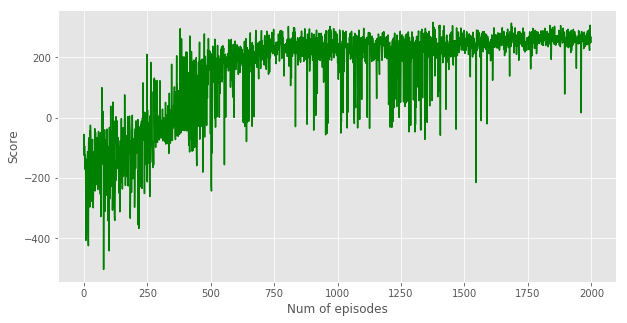

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [17]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/Double_DQN_{ENV_NAME}.pth'));

In [18]:
num_of_episodes = 20

for i_episode in range(1, num_of_episodes+1):
    
    state = env.reset()
    for time_step in range(200):
        
        # select an action
        action = agent.act(state)
        env.render()
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break

env.close()

---